In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.3 MB/s eta 0:00:00


In [ ]:
!pip install feature_engine

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 378.6/378.6 kB 5.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import warnings
import joblib
import plotly.express as px
from google.colab import drive
from datetime import date, timedelta
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, CatBoostRegressor
import random
# from plot_metric.functions import BinaryClassification

warnings.filterwarnings('ignore')
pd.options.display.max_columns = 500

from google.colab import auth
import gspread
from google.auth import default

auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)
drive.mount('/content/drive',  force_remount=True)

Mounted at /content/drive


In [ ]:
import json
data = {
  "account": "",
  "client_id": "764086051850-6qr4p6gpi6hn506pt8ejuq83di341hur.apps.googleusercontent.com",
  "client_secret": "d-FL95Q19q7MQmFpd7hHD0Ty",
  "quota_project_id": "dev-sd-lake",
  "refresh_token": "1//05nz9IRnR1e2JCgYIARAAGAUSNwF-L9Ir_zi7EkfNFJb02e5XxL3e4Qicf7BN708CjMo66DuPPMhkd09jS6lIra-zubUPFGORcyU",
  "type": "authorized_user",
  "universe_domain": "googleapis.com"
}
json_data = json.dumps(data)
!echo '{json_data}' > '/content/.config/application_default_credentials.json'

In [ ]:
from google.cloud import bigquery

client = bigquery.Client(project='dev-sd-lake')

product_listings_query = """
SELECT * FROM pollen.product_listings;
"""

product_listings = client.query_and_wait(product_listings_query).to_dataframe()


client = bigquery.Client(project='dev-sd-lake')

products_query = """
SELECT * FROM pollen.products;
"""

products = client.query_and_wait(products_query).to_dataframe()


client = bigquery.Client(project='dev-sd-lake')

product_categories_query = """
SELECT * FROM pollen.product_categories;
"""

product_categories = client.query_and_wait(product_categories_query).to_dataframe()


client = bigquery.Client(project='dev-sd-lake')

product_subcategories_query = """
SELECT * FROM pollen.product_subcategories;
"""

product_subcategories = client.query_and_wait(product_subcategories_query).to_dataframe()

client = bigquery.Client(project='dev-sd-lake')

sellers_query = """
SELECT * FROM pollen.sellers;
"""

sellers = client.query_and_wait(sellers_query).to_dataframe()

In [ ]:
offers_query = """
SELECT * FROM pollen.offers;
"""

offers = client.query_and_wait(offers_query).to_dataframe()

In [ ]:
orders_level_1_query = """
SELECT * FROM pollen.orders_level_1;
"""

orders_level_1 = client.query_and_wait(orders_level_1_query).to_dataframe()

In [ ]:
orders_level_2_query = """
SELECT * FROM pollen.orders_level_2;
"""

orders_level_2 = client.query_and_wait(orders_level_2_query).to_dataframe()

In [ ]:
sellers = sellers[['seller_name', 'persona_seller_type']].drop_duplicates()

In [ ]:
print(product_listings.shape, products.shape, product_categories.shape, product_subcategories.shape, sellers.shape, offers.shape)

(99164, 41) (99172, 9) (22, 3) (111, 4) (109, 2) (18167, 43)


In [ ]:
# spr = gc.open_by_url('https://docs.google.com/spreadsheets/d/1mPSsaPBJBGjQhSoXDdqE7P8RbFsjZHNVZKojOWQo37s/edit?gid=1037564806#gid=1037564806')
# wks = spr.worksheet('Proposed')
# rows = wks.get_all_values()
# df_inv = pd.DataFrame.from_records(rows)
# df_inv

In [ ]:
def get_order_date(df_order_sheet1, df_order_sheet2):
  order_date_to_tracking_no_mapping = df_order_sheet1[['tracking_no', 'order_date']].drop_duplicates()
  df_order_sheet2 = pd.merge(df_order_sheet2, order_date_to_tracking_no_mapping, 'left',  on = ['tracking_no'])
  df_order_sheet2.drop('date_of_order', axis = 1, inplace = True)
  df_order = df_order_sheet2.copy()
  return df_order

orders = get_order_date(orders_level_1, orders_level_2)

In [ ]:
orders = orders.drop_duplicates(subset = ['sku_number', 'expiry_date', 'tracking_no'])
offers = offers.drop_duplicates(subset = ['sku_number', 'expiry_date', 'tracking_no'])
offers = offers.rename(columns = {'total_units' : 'total_units_offered'})
orders = orders.rename(columns = {'total_units' : 'total_units_ordered', 'total_offer_price_usd' : 'total_order_price_usd'})

offers = pd.merge(offers, orders[['sku_number', 'expiry_date', 'tracking_no', 'total_units_ordered', 'recovery_rate_percentage', 'total_order_price_usd']], 'left', on = ['sku_number', 'expiry_date', 'tracking_no'])

In [ ]:
product_subcategories = product_subcategories.rename(columns = {'id' : 'subcategory_id', 'name' : 'product_subcategory'})
product_categories = product_categories.rename(columns = {'id' : 'category_id', 'name' : 'product_category'})

products = pd.merge(products, product_categories, 'left', on = 'category_id')
products = pd.merge(products, product_subcategories[['subcategory_id', 'product_subcategory']], 'left', on = 'subcategory_id')

In [ ]:
products = products.rename(columns = {'id' : 'product_id'})
products = products.drop(['parent_product_id', 'created_at', 'updated_at', 'category_id', 'subcategory_id'], axis = 1)

product_listings = product_listings.drop(['created_at', 'updated_at', 'pollen_updated_price_per_unit_local',
                       'barcode', 'barcode_key', 'manufactured_date', 'batch_number', 'image_links', 'usd_conversion', 'scoring'], axis = 1)
product_listings = pd.merge(product_listings, products, 'left', on = 'product_id')

In [ ]:
product_listings.head(2)

,id,product_id,seller_id,record_id,seller_name,expiry_date,package_type,qty_of_carton,units_per_package_type,total_number_of_items,currency,retail_price_per_unit_local,asking_price_per_unit_local,pack_size_number,pack_size_unit,cbm_carton,length,breadth,height,unit_dimensions,weight_per_carton_kg,warehouse_address,warehouse_country,country_of_origin,package_labeled_language,product_restriction,priority,retail_price_per_unit_usd,asking_price_per_unit_usd,inventory_class,updated_on,sku_number,sku_product_name,brand,product_category,description,product_subcategory
0,7c765b8d-4858-42f3-bdcd-d39e07146f58,7468eef6-5131-48d9-89d3-e13006c70311,SE1712631761502,SE1712631761502G4311200,L'Oreal Indonesia,2025-01-01,Carton,64.20,60.0,3852.0,IDR,24900.0,5991.5,31.0,g,0.01,254.0,156.0,219.0,MM,2.24,Bekasi,Indonesia,-,-,NaN,P2,1.53,0.37,CORE,2024-05-28,G4311200,GRN 2 STEP PW MASK B5 GOJI EB,GARNIER,SKIN CARE,SKIN CARE,MASKS & EXFOLIATORS
1,b419d6ba-dd0c-4283-83de-df3a38e7a9be,9eb95253-892b-4eea-9fa0-33a79786d3d1,SE1712631761502,SE1712631761502G4218000,L'Oreal Indonesia,2025-01-28,Carton,58.43,60.0,3506.0,IDR,23400.0,6552.7,19.7,g,0.01,185.0,150.0,197.0,MM,1.42,Bekasi,Indonesia,-,-,NaN,P2,1.44,0.40,CORE,2024-05-28,G4218000,GRN 5 MIN AMP MASK WATERMELON EB,GARNIER,SKIN CARE,SKIN CARE,MASKS & EXFOLIATORS


In [ ]:
product_listings.inventory_class.value_counts()

,count
inventory_class,
CORE,66703
NON_CORE,32461


In [ ]:
df_inv = product_listings[product_listings.inventory_class == 'CORE']
non_core_inv = product_listings[product_listings.inventory_class == 'NON_CORE']
df_inv = df_inv.reset_index(drop = True)
non_core_inv = non_core_inv.reset_index(drop = True)

In [ ]:
cols_list_underscore_cleaning = ['sku_product_name', 'brand', 'product_category', 'product_subcategory', 'warehouse_country',
            'country_of_origin', 'pack_label_language', 'product_restricted_countries', 'shelf_life_bucket']

inv_cols_list_to_change_dtypes = ['qty_of_cartons', 'units_per_cartons', 'retail_price_per_case_(local)', 'retail_price_per_case_(usd)', 'asking_price_per_case_(local)',
                              'asking_price_per_case_(usd)', 'total_retail_price_(local)', 'total_retail_price_(usd)', 'total_asking_price_(local)',
                              'total_asking_price_(usd)', 'pack_size_(number)', 'total_cbm', 'cbm_per_case', 'package_dimensions_per_package_type_(length)',
                              'package_dimensions_per_case_(width)', 'package_dimensions_per_case_(height)', 'net_weight_\nper_unit(kg)', 'net_weight_per_case_(kg)',
                              'gross_weight_per_case_(kg)', 'total_net_weight_(kg)', 'total_gross_weight_(kg)', 'cases_per_pallet', 'number_of_pallets', 'discount',
                              'shelf_remaining_days']

record_attributes = ['sku_number', 'sku_name', 'brand', 'product_category', 'product_subcategory', 'retail_price_per_unit_local', 'currency']

n_days_before_date = pd.to_datetime(date.today() - timedelta(days = 14))

THRESHOLD = 0.65

In [ ]:
def dropping_null_brand_cat_subcats(df_inv):
  df_inv = df_inv[~df_inv.brand.isnull()]
  df_inv = df_inv[~df_inv.product_category.isnull()]
  df_inv = df_inv[~df_inv.product_subcategory.isnull()]
  return df_inv

def cols_to_lower_rem_space(df, cols_list):
  for col in ['sku_name', 'product_name', 'brand', 'brand_', 'product_description', 'product_category', 'product_sub_category', 'product_subcategory',\
              'warehouse_location', 'buyer', 'seller', 'package_type', 'deal_type', 'origin_', 'destination', 'region_of_export', \
              'domestic_export', 'order_type', 'country', 'currency', 'country_of_origin', 'pack_label_language', 'dangerous_goods\n(y/n)', 'shelf_life_bucket',
              'relavant_(r)/ir-relavant(ir)', 'product_restricted_countries', 'store_name', 'quarter', 'temp_reference', 'tracking_no', 'offer_type', 'fiscal_month',
              'proposed_buyer_product_preferences', 'product_shelf_life_months', 'priority', 'seller', 'lms_seller_id', 'persona', 'core_vs._\nnon_core', 'sku_product_name',
              'warehouse_country', 'warehouse_address', 'measurement_units', 'listing_currency', 'manufacturing_country', 'lbh_measurement_units', 'package_type', 'seller_name',
              'pack_size_unit', 'package_labeled_language', 'inventory_class', 'description', 'unit_dimensions']:
              if col in cols_list:
                df[col] = df[col].str.lower().str.replace(' ', '_')
  return df

def remove_starting_and_trailing_underscores(x):
  if x != '':
    if x[0] == '_':
      for i in range(len(x)):
        if x[i] != '_':
          start = i
          break
      x = x[start:]
    if x[-1] == '_':
      for i in reversed(range(len(x))):
        if x[i] != '_':
          end = i
          break
      x = x[:end+1]
  return x

def cleaning_underscores_inv_data(df_inv, col_list):
  for col in col_list:
    print(col)
    df_inv[col] = df_inv[col].apply(remove_starting_and_trailing_underscores)
  return df_inv

def drop_dups_and_clean(df_inv):
  print('Dropping above duplicates ...')
  df_inv = df_inv.drop_duplicates()
  return df_inv

# Non Core

In [ ]:
df_inv = dropping_null_brand_cat_subcats(df_inv)
df_inv = cols_to_lower_rem_space(df_inv, df_inv.columns)
df_inv = drop_dups_and_clean(df_inv)

non_core_inv = cols_to_lower_rem_space(non_core_inv, non_core_inv.columns)

Dropping above duplicates ...


In [ ]:
non_core_inv.head(2)

,id,product_id,seller_id,record_id,seller_name,expiry_date,package_type,qty_of_carton,units_per_package_type,total_number_of_items,currency,retail_price_per_unit_local,asking_price_per_unit_local,pack_size_number,pack_size_unit,cbm_carton,length,breadth,height,unit_dimensions,weight_per_carton_kg,warehouse_address,warehouse_country,country_of_origin,package_labeled_language,product_restriction,priority,retail_price_per_unit_usd,asking_price_per_unit_usd,inventory_class,updated_on,sku_number,sku_product_name,brand,product_category,description,product_subcategory
0,2d28d351-f531-42d7-abc1-fee72e225c53,1e18e385-f133-4fb3-95f4-b56cb1419369,SE1712631761542,SE171263176154204R3I1MKJPD97H7OBZ60UTU1Z,acommerce_singapore,2023-05-31,pieces,NaN,NaN,6.0,sgd,19.9,1.99,NaN,None,0.0,10.0,10.0,10.0,cm,0.50,sg-acom01,None,None,None,NaN,p1,15.116504,1.511650,non_core,2023-01-25,04R3I1MKJPD97H7OBZ60UTU1Z,l'oreal_paris_color_riche_satin_105_nude_in_paris,l'oreal_paris,makeup,makeup,lip_makeup
1,063c43ca-8297-4bea-9bbf-3ff2e9fd8376,3a7331cf-dbd4-4cb4-b791-982833ff97ff,SE1712631761542,SE171263176154211YAP8LR1W3OQSFJGWCLTD1DQ,acommerce_singapore,2023-05-31,pieces,NaN,NaN,160.0,sgd,2.0,0.20,NaN,None,0.0,8.0,5.0,0.2,cm,0.15,sg-acom02,None,None,None,NaN,p1,1.519247,0.151925,non_core,2023-01-25,11YAP8LR1W3OQSFJGWCLTD1DQ,garnier_serum_mask_-_pomegranate_(replumping),garnier,skin_care,skin_care,masks_&_exfoliators


In [ ]:
non_core_inv = non_core_inv.rename(columns = {'total_number_of_items' : 'total_units'})
non_core_inv['updated_on'] = pd.to_datetime(non_core_inv['updated_on'])
non_core_inv['expiry_date'] = pd.to_datetime(non_core_inv['expiry_date'])

In [ ]:
print(non_core_inv.shape)
non_core_inv = non_core_inv.drop_duplicates(subset = ['sku_number', 'expiry_date', 'updated_on', 'seller_name'])
print(non_core_inv.shape)

(32461, 37)
(29476, 37)


In [ ]:
offers = offers.rename(columns = {'seller' : 'seller_name'})
offers['date_of_offer'] = pd.to_datetime(offers['date_of_offer'])
offers['seller_name'] = offers['seller_name'].str.lower()
offers['total_units_ordered'] = offers['total_units_ordered'].str.replace(',', '')
offers['total_units_ordered'] = offers['total_units_ordered'].astype(float)

In [ ]:
def merge_non_core_inv_and_offer(non_core_inv, df_offer):
  temp = pd.merge(non_core_inv, df_offer[['sku_number', 'seller_name', 'date_of_offer', 'actual', 'tracking_no', 'buyer', 'total_units_ordered',
                                          'recovery_rate_percentage', 'offer_price_per_unit_usd', 'total_order_price_usd']], 'left', on = ['sku_number', 'seller_name'])
  # temp['updated_on'] = pd.to_datetime(temp['updated_on'])
  temp['offer_day_diff_updated_inv'] = (temp['date_of_offer'] - temp['updated_on']).dt.days
  # avoiding future entry from same sku and seller to get filtered out hence nulling it as will remain in the dataframe
  temp['offer_day_diff_updated_inv'] = np.where(temp.offer_day_diff_updated_inv < 0, np.nan, temp['offer_day_diff_updated_inv'])
  temp = temp[(temp.offer_day_diff_updated_inv >= 0) | (temp.offer_day_diff_updated_inv.isnull())]
  df_non_core_inv_min_offer_day_diff_updated_inv = temp.groupby(['sku_number', 'seller_name', 'date_of_offer']).agg({'offer_day_diff_updated_inv' : 'min'}).reset_index()\
                                        .rename(columns = {'offer_day_diff_updated_inv' : 'min_offer_day_diff_updated_inv'})
  temp = pd.merge(temp, df_non_core_inv_min_offer_day_diff_updated_inv, 'left', on = ['sku_number', 'seller_name', 'date_of_offer'])
  temp = temp[(temp.offer_day_diff_updated_inv == temp.min_offer_day_diff_updated_inv) | (temp.offer_day_diff_updated_inv.isnull())]
  temp.drop('min_offer_day_diff_updated_inv', axis = 1, inplace = True)
  return temp

In [ ]:
non_core_inv = merge_non_core_inv_and_offer(non_core_inv, offers)
# non_core_inv['sell_thru_rate'] = non_core_inv['total_units_ordered'] / non_core_inv['total_units']
# non_core_inv['sell_thru_rate'] = np.where(non_core_inv['sell_thru_rate'] > 1, 1, non_core_inv['sell_thru_rate'])

In [ ]:
non_core_inv['shelf_life_remaining_days'] = (non_core_inv['expiry_date'] - non_core_inv['updated_on']).dt.days

In [ ]:
temp = non_core_inv[['sku_number', 'brand', 'product_category', 'product_subcategory', 'expiry_date', 'seller_name', 'updated_on', 'priority', 'total_units', 'shelf_life_remaining_days',
                     'warehouse_country', 'total_units_ordered', 'recovery_rate_percentage']].sort_values(by = ['sku_number', 'brand', 'product_category', 'product_subcategory',
                      'expiry_date', 'seller_name', 'updated_on', 'priority', 'warehouse_country'])
temp = temp.reset_index(drop = True)

In [ ]:
def get_prev_inv_occurence_next_to_current_for_non_core_inv(temp):
  new_col_names_for_shifted_inv = dict()
  for i in temp.columns:
    new_col_names_for_shifted_inv[i] = i+'_prev'

  temp_shifted = temp.shift(1)
  temp_shifted = temp_shifted.rename(columns = new_col_names_for_shifted_inv)
  temp = pd.concat([temp, temp_shifted], axis=1)
  return temp

# not taking expiry into account

def get_repeated_inv_and_mean_depletion_for_non_core_inv(temp):
  repeated_inv = temp[(temp.sku_number == temp.sku_number_prev) & (temp.seller_name == temp.seller_name_prev)]
  repeated_inv['depletion'] = repeated_inv['total_units_prev'] - repeated_inv['total_units']
  repeated_inv['time'] = (repeated_inv['updated_on'] - repeated_inv['updated_on_prev']).dt.days
  repeated_inv = repeated_inv.drop_duplicates(subset = ['sku_number', 'brand', 'product_category', 'product_subcategory', 'expiry_date', \
                            'seller_name', 'updated_on', 'priority'])[['sku_number', 'brand', 'product_category', 'product_subcategory', 'expiry_date', 'seller_name', 'updated_on',\
                                                                        'priority', 'depletion', 'time', 'total_units_prev', 'total_units', 'priority_prev',\
                                                                        'shelf_life_remaining_days_prev', 'warehouse_country_prev', 'total_units_ordered_prev',
                                                                        'recovery_rate_percentage_prev']]

  return repeated_inv

## Recommendation - measure depletion at some other level, exclude skus as many skus don't repeat and many rows are getting dropped

In [ ]:
temp = get_prev_inv_occurence_next_to_current_for_non_core_inv(temp)
repeated_inv_non_core = get_repeated_inv_and_mean_depletion_for_non_core_inv(temp)
repeated_inv_non_core = repeated_inv_non_core.reset_index(drop = True)
repeated_inv_non_core['priority'] = np.where(repeated_inv_non_core.priority != repeated_inv_non_core.priority_prev, \
                                                   repeated_inv_non_core.priority_prev, repeated_inv_non_core.priority)

In [ ]:
# 90 days sales life cycle
repeated_inv_non_core = repeated_inv_non_core[repeated_inv_non_core.time <= 90]

mean_depletion_per_cat_non_core_inv = repeated_inv_non_core.groupby(['product_category']).depletion.mean().reset_index().sort_values(by = 'depletion')

low_depletion_cats = list(mean_depletion_per_cat_non_core_inv[mean_depletion_per_cat_non_core_inv['depletion'] <= mean_depletion_per_cat_non_core_inv.depletion.quantile(0.33)].product_category)
mid_depletion_cats = list(mean_depletion_per_cat_non_core_inv[mean_depletion_per_cat_non_core_inv['depletion'] <= mean_depletion_per_cat_non_core_inv.depletion.quantile(0.67)].product_category)
mid_depletion_cats = [i for i in mid_depletion_cats if i not in low_depletion_cats]
high_depletion_cats = list(mean_depletion_per_cat_non_core_inv[mean_depletion_per_cat_non_core_inv['depletion'] <= mean_depletion_per_cat_non_core_inv.depletion.quantile(1)].product_category)
high_depletion_cats = [i for i in high_depletion_cats if i not in low_depletion_cats + mid_depletion_cats]

print(low_depletion_cats, '\n', mid_depletion_cats, '\n', high_depletion_cats)

['beverages', 'health_&_supplments', 'industrial', 'oral_care', 'skin_care'] 
 ['baby', 'hair_care', 'home_care', 'fashion_-_accessories'] 
 ['fragrance', 'sports,_fitness,_&_outdoors', 'makeup', 'home', 'food']


In [ ]:
def set_depletion_non_core(row):
  if row['depletion'] < 0:
    return row['total_units_prev']
  elif row['product_category'] in high_depletion_cats and row['time'] <= 20:
    return row['depletion']
  elif row['product_category'] in high_depletion_cats and row['time'] > 20:
    return row['total_units_prev']
  elif row['product_category'] in mid_depletion_cats and row['time'] <= 45:
    return row['depletion']
  elif row['product_category'] in mid_depletion_cats and row['time'] > 45:
    return row['total_units_prev']
  elif row['product_category'] in low_depletion_cats and row['time'] <= 60:
    return row['depletion']
  elif row['product_category'] in low_depletion_cats and row['time'] > 60:
    return row['total_units_prev']

In [ ]:
repeated_inv_non_core['depletion'] = repeated_inv_non_core.apply(set_depletion_non_core, axis=1)

In [ ]:
def remove_percent_sign(x):
  if pd.isna(x):
    return x
  else:
    return x[:-1]
repeated_inv_non_core['recovery_rate_percentage_prev'] = repeated_inv_non_core['recovery_rate_percentage_prev'].apply(remove_percent_sign)
repeated_inv_non_core['recovery_rate_percentage_prev'] = np.where(repeated_inv_non_core['recovery_rate_percentage_prev'] == '', np.nan, repeated_inv_non_core['recovery_rate_percentage_prev'])
repeated_inv_non_core['recovery_rate_percentage_prev'] = repeated_inv_non_core['recovery_rate_percentage_prev'].astype(float)
repeated_inv_non_core['recovery_rate_percentage_prev'] = np.where(repeated_inv_non_core['recovery_rate_percentage_prev'].isnull(), 0 , repeated_inv_non_core['recovery_rate_percentage_prev'])
repeated_inv_non_core['total_units_ordered_prev'] = np.where(repeated_inv_non_core['total_units_ordered_prev'].isnull(), 0, repeated_inv_non_core['total_units_ordered_prev'])

In [ ]:
repeated_inv_non_core = repeated_inv_non_core.rename(columns = {'total_units_ordered_prev' : 'pollen_liquidated_units',
                                                                'recovery_rate_percentage_prev' : 'pollen_recovery_rate_percentage'})

In [ ]:
repeated_inv_non_core.sample(2)

,sku_number,brand,product_category,product_subcategory,expiry_date,seller_name,updated_on,priority,depletion,time,total_units_prev,total_units,priority_prev,shelf_life_remaining_days_prev,warehouse_country_prev,pollen_liquidated_units,pollen_recovery_rate_percentage
2015,WAB9M46,sariwangi,beverages,"coffee,_tea,_infusions",2026-04-06,sirclo,2024-09-09,p3,0.0,0,6624.0,6624.0,p3,574.0,indonesia,0.0,0.0
524,8851932438599,dove,hair_care,shampoo,2025-08-01,acommerce_thailand,2024-06-14,p1,0.0,43,164.0,164.0,p1,456.0,None,0.0,0.0


In [ ]:
# non_core_inv['non_core_inv_keys'] = list(non_core_inv['sku_number'].astype(str) + '_' + non_core_inv['expiry_date'].astype(str) + '_'
#                          + non_core_inv['seller_name'].astype(str) + '_' + non_core_inv['updated_on'].astype(str))

# repeated_inv_non_core_keys = list(repeated_inv_non_core['sku_number'].astype(str) + '_' + repeated_inv_non_core['expiry_date'].astype(str) + '_'
#                          + repeated_inv_non_core['seller_name'].astype(str) + '_' + repeated_inv_non_core['updated_on'].astype(str))

# not_repeated_non_core_inv = non_core_inv[~non_core_inv['non_core_inv_keys'].isin(repeated_inv_non_core_keys)][['sku_number', 'brand', 'product_category','product_subcategory',
#                                                                                                   'seller_name','priority', 'total_units', 'shelf_life_remaining_days', 'warehouse_country']]

# not_repeated_non_core_inv['pollen_liquidated_units'] = 0
# not_repeated_non_core_inv['pollen_recovery_rate_percentage'] = 0

# not_repeated_non_core_inv = not_repeated_non_core_inv.rename(columns = {'shelf_life_remaining_days' : 'shelf_life_remaining_days_prev', 'warehouse_country' : 'warehouse_country_prev',
#                                                                         'total_units' : 'total_units_prev'})

# Core

In [ ]:
offers = offers.rename(columns = {'seller_name' : 'seller_short'})

seller_name_to_short_form = {'unilever_indonesia' : 'ulid', 'unilever_malaysia' : 'ulmy', 'unilever_philippines' : 'ulph', 'unilever_thailand' : 'ulth', 'unilever_singapore' : 'ulsg',
                             "l'oreal_malaysia" : "lomy", "l'oreal_philippines" : 'loph', "l'oreal_thailand" : "loth", "l'oreal_india" : "loin", "l'oreal_indonesia" : "loid"}

df_inv['updated_on'] = pd.to_datetime(df_inv['updated_on'])

def apply_seller_short(x):
  if x in seller_name_to_short_form.keys():
    return seller_name_to_short_form[x]
  else:
    return x

df_inv['seller_short'] = df_inv['seller_name'].apply(apply_seller_short)

offers = offers[offers['expiry_date'] != '-']
offers['expiry_date'] = pd.to_datetime(offers['expiry_date'], format = "%d-%b-%Y")
df_inv['expiry_date'] = pd.to_datetime(df_inv['expiry_date'])

In [ ]:
def merge_inv_and_offer(df_inv, df_offer):
  df_inv = pd.merge(df_inv, df_offer[['sku_number', 'expiry_date', 'seller_short', 'date_of_offer', 'actual', 'tracking_no', 'buyer', 'total_units_ordered',
                                      'recovery_rate_percentage', 'offer_price_per_unit_usd', 'total_order_price_usd']], 'left', on = ['sku_number', 'expiry_date', 'seller_short'])
  df_inv['offer_day_diff_updated_inv'] = (df_inv['date_of_offer'] - df_inv['updated_on']).dt.days
  df_inv = df_inv[(df_inv.offer_day_diff_updated_inv >= 0) | (df_inv.offer_day_diff_updated_inv.isnull())]
  df_min_offer_day_diff_updated_inv = df_inv.groupby(['sku_number', 'expiry_date', 'seller_short', 'date_of_offer']).agg({'offer_day_diff_updated_inv' : 'min'}).reset_index()\
                                      .rename(columns = {'offer_day_diff_updated_inv' : 'min_offer_day_diff_updated_inv'})
  df_inv = pd.merge(df_inv, df_min_offer_day_diff_updated_inv, 'left', on = ['sku_number', 'expiry_date', 'seller_short', 'date_of_offer'])
  df_inv = df_inv[(df_inv.offer_day_diff_updated_inv == df_inv.min_offer_day_diff_updated_inv) | (df_inv.offer_day_diff_updated_inv.isnull())]
  df_inv.drop('min_offer_day_diff_updated_inv', axis = 1, inplace = True)
  return df_inv

In [ ]:
df_inv = merge_inv_and_offer(df_inv, offers)
df_inv['total_units_ordered'] = df_inv['total_units_ordered'].fillna(0)
# df_inv['sell_thru_rate'] = df_inv['total_units_ordered'] / df_inv['total_number_of_items']
# df_inv['sell_thru_rate'] = np.where(df_inv['sell_thru_rate'] > 1, 1, df_inv['sell_thru_rate'])
df_inv['shelf_life_remaining_days'] = (df_inv['expiry_date'] - df_inv['updated_on']).dt.days

In [ ]:
# dropping duplicates considering all columns except the ids
k = list(set(df_inv.columns) - set([i for i in df_inv.columns if i.endswith('id')]))
df_inv = df_inv.drop_duplicates(subset = k)

In [ ]:
df_inv = df_inv.rename(columns = {'total_number_of_items' : 'total_units'})
df_inv['updated_on'] = pd.to_datetime(df_inv['updated_on'])
df_inv['expiry_date'] = pd.to_datetime(df_inv['expiry_date'])
df_inv = df_inv[df_inv.sku_number != '']
df_inv['shelf_life_remaining_days'] = (df_inv['expiry_date'] - df_inv['updated_on']).dt.days

def remove_percent_sign(x):
  if pd.isna(x):
    return x
  else:
    return x[:-1]
df_inv['recovery_rate_percentage'] = df_inv['recovery_rate_percentage'].apply(remove_percent_sign)
df_inv['recovery_rate_percentage'] = np.where(df_inv['recovery_rate_percentage'] == '', np.nan, df_inv['recovery_rate_percentage'])
df_inv['recovery_rate_percentage'] = df_inv['recovery_rate_percentage'].astype(float)
df_inv['recovery_rate_percentage'] = np.where(df_inv['recovery_rate_percentage'].isnull(), 0 , df_inv['recovery_rate_percentage'])

In [ ]:
key_to_total_units_ordered = df_inv.groupby(['sku_number', 'seller_name', 'expiry_date', 'updated_on']).agg({'total_units_ordered' : 'sum'}).reset_index().rename(columns =
                                                {'total_units_ordered' : 'total_units_ordered_sum'})
df_inv = pd.merge(df_inv, key_to_total_units_ordered, 'left', on = ['sku_number', 'seller_name', 'expiry_date', 'updated_on'])

In [ ]:
temp = df_inv[['sku_number', 'brand', 'product_category', 'product_subcategory', 'expiry_date', 'seller_name', 'updated_on', 'priority', 'total_units',
               'shelf_life_remaining_days', 'warehouse_country', 'total_units_ordered_sum', 'recovery_rate_percentage']]\
                  .sort_values(by = ['sku_number', 'brand', 'product_category', 'product_subcategory', 'expiry_date', 'seller_name', 'updated_on', 'priority', 'warehouse_country'])
temp = temp.reset_index(drop = True)

In [ ]:
print(temp.shape)
print(temp.drop_duplicates(subset = ['sku_number', 'brand', 'product_category', 'product_subcategory', 'expiry_date', 'seller_name', 'updated_on', 'priority', 'total_units']).shape)

(54892, 13)
(51240, 13)


In [ ]:
def get_prev_inv_occurence_next_to_current(temp):
  new_col_names_for_shifted_inv = dict()
  for i in temp.columns:
    new_col_names_for_shifted_inv[i] = i+'_prev'

  temp_shifted = temp.shift(1)
  temp_shifted = temp_shifted.rename(columns = new_col_names_for_shifted_inv)
  temp = pd.concat([temp, temp_shifted], axis=1)
  return temp

def get_repeated_inv_and_mean_depletion(temp):
  repeated_inv = temp[(temp.sku_number == temp.sku_number_prev) & (temp.expiry_date == temp.expiry_date_prev) & (temp.seller_name == temp.seller_name_prev)]
  repeated_inv['depletion'] = repeated_inv['total_units_prev'] - repeated_inv['total_units']
  repeated_inv['time'] = (repeated_inv['updated_on'] - repeated_inv['updated_on_prev']).dt.days
  repeated_inv = repeated_inv.drop_duplicates(subset = ['sku_number', 'brand', 'product_category', 'product_subcategory', 'expiry_date', \
                            'seller_name', 'updated_on', 'priority'])[['sku_number', 'brand', 'product_category', 'product_subcategory', 'expiry_date', 'seller_name', 'updated_on',\
                                                                        'priority', 'depletion', 'time', 'total_units_prev', 'total_units', 'priority_prev',\
                                                                        'shelf_life_remaining_days_prev', 'warehouse_country_prev', 'total_units_ordered_sum_prev',
                                                                        'recovery_rate_percentage_prev']]
  return repeated_inv

In [ ]:
temp = get_prev_inv_occurence_next_to_current(temp)
repeated_inv = get_repeated_inv_and_mean_depletion(temp)

# since current was match to previous, hence correcting the current row previous priority order to previous one
repeated_inv['priority'] = np.where(repeated_inv.priority != repeated_inv.priority_prev, repeated_inv.priority_prev, repeated_inv.priority)

In [ ]:
print(repeated_inv[repeated_inv.time > 90].shape)
print('Removing above number of rows as sales cycle is fixed to 90 days max for any cat or sub cat after which it is assumed to finish')
repeated_inv = repeated_inv[repeated_inv.time <= 90]

(2899, 17)
Removing above number of rows as sales cycle is fixed to 90 days max for any cat or sub cat after which it is assumed to finish


In [ ]:
mean_depletion_per_cat_core_inv = repeated_inv.groupby(['product_category']).depletion.mean().reset_index().sort_values(by = 'depletion')

In [ ]:
low_depletion_cats = list(mean_depletion_per_cat_core_inv[mean_depletion_per_cat_core_inv['depletion'] <= mean_depletion_per_cat_core_inv.depletion.quantile(0.33)].product_category)
mid_depletion_cats = list(mean_depletion_per_cat_core_inv[mean_depletion_per_cat_core_inv['depletion'] <= mean_depletion_per_cat_core_inv.depletion.quantile(0.67)].product_category)
mid_depletion_cats = [i for i in mid_depletion_cats if i not in low_depletion_cats]
high_depletion_cats = list(mean_depletion_per_cat_core_inv[mean_depletion_per_cat_core_inv['depletion'] <= mean_depletion_per_cat_core_inv.depletion.quantile(1)].product_category)
high_depletion_cats = [i for i in high_depletion_cats if i not in low_depletion_cats + mid_depletion_cats]

In [ ]:
print(low_depletion_cats, '\n', mid_depletion_cats, '\n', high_depletion_cats)

['beverages', 'fashion_-_accessories', 'home', 'oral_care'] 
 ['makeup', 'fragrance', 'skin_care'] 
 ['baby', 'hair_care', 'home_care', 'food']


In [ ]:
# do disposal correction

In [ ]:
def set_depletion(row):
  if row['depletion'] < 0:
    return row['total_units_prev']
  elif row['product_category'] in high_depletion_cats and row['time'] <= 20:
    return row['depletion']
  elif row['product_category'] in high_depletion_cats and row['time'] > 20:
    return row['total_units_prev']
  elif row['product_category'] in mid_depletion_cats and row['time'] <= 45:
    return row['depletion']
  elif row['product_category'] in mid_depletion_cats and row['time'] > 45:
    return row['total_units_prev']
  elif row['product_category'] in low_depletion_cats and row['time'] <= 60:
    return row['depletion']
  elif row['product_category'] in low_depletion_cats and row['time'] > 60:
    return row['total_units_prev']

In [ ]:
repeated_inv['depletion'] = repeated_inv.apply(set_depletion, axis=1)
repeated_inv = repeated_inv.reset_index(drop = True)

In [ ]:
repeated_inv = repeated_inv.rename(columns = {'total_units_ordered_sum_prev' : 'pollen_liquidated_units', 'recovery_rate_percentage_prev' : 'pollen_recovery_rate_percentage'})

In [ ]:
COLUMNS_FOR_DEPLETION_MODELING = ['sku_number', 'brand', 'product_category', 'product_subcategory', 'seller_name', 'time']

In [ ]:
repeated_inv = repeated_inv[COLUMNS_FOR_DEPLETION_MODELING + ['priority', 'total_units_prev', 'depletion', 'shelf_life_remaining_days_prev', 'warehouse_country_prev',
                                                              'pollen_liquidated_units', 'pollen_recovery_rate_percentage']]
repeated_inv_non_core = repeated_inv_non_core[COLUMNS_FOR_DEPLETION_MODELING + ['priority', 'total_units_prev', 'depletion', 'shelf_life_remaining_days_prev', 'warehouse_country_prev',
                                                                                'pollen_liquidated_units', 'pollen_recovery_rate_percentage']]
print(repeated_inv.shape, repeated_inv_non_core.shape)

(19109, 13) (979, 13)


In [ ]:
repeated_inv = pd.concat([repeated_inv, repeated_inv_non_core], ignore_index=True)
repeated_inv.depletion['depletion'] = np.where(repeated_inv.depletion < repeated_inv.pollen_liquidated_units, repeated_inv.pollen_liquidated_units, repeated_inv.depletion)
repeated_inv.shape

(20088, 13)

In [ ]:
repeated_inv.sample(2)

,sku_number,brand,product_category,product_subcategory,seller_name,time,priority,total_units_prev,depletion,shelf_life_remaining_days_prev,warehouse_country_prev,pollen_liquidated_units,pollen_recovery_rate_percentage
9671,G1182500,garnier,skin_care,cleansers_&_toners,l'oreal_malaysia,28,p1,8.0,2.0,171.0,malaysia,0.0,0.0
2438,67829091,cream_silk,hair_care,conditioner,unilever_philippines,56,p3,24192.0,24192.0,698.0,philippines,0.0,0.0


In [ ]:
def correct_p1_depletion(df):
  if df['priority'] == 'p1' and np.random.uniform(low=1, high=99, size=(1,))[0] <= 80:
    return np.random.uniform(low=5, high=20, size=(1,))[0]/ 100 * df['depletion']
  else:
    return df['depletion']

repeated_inv['depletion'] = repeated_inv.apply(correct_p1_depletion, axis = 1)
repeated_inv['pollen_liquidated_units'] = np.where(repeated_inv.pollen_liquidated_units > repeated_inv.depletion, repeated_inv.depletion, repeated_inv.pollen_liquidated_units)
repeated_inv = repeated_inv.reset_index(drop = True)

In [ ]:
high_shelf_life_dummy = repeated_inv.copy()

def get_dummy_high_shelf_life(df):
    if pd.isna(df['shelf_life_remaining_days_prev']):
      return df['shelf_life_remaining_days_prev']
    else:
      return np.random.uniform(
            low=df['shelf_life_remaining_days_prev'],
            high=1.5 * df['shelf_life_remaining_days_prev'], size=(1,))[0]

high_shelf_life_dummy['shelf_life_remaining_days_prev'] = high_shelf_life_dummy.apply(get_dummy_high_shelf_life, axis = 1)
high_shelf_life_dummy['orig_shelf_life'] = repeated_inv['shelf_life_remaining_days_prev']
high_shelf_life_dummy['shelf_life_factor'] = high_shelf_life_dummy['shelf_life_remaining_days_prev'] / high_shelf_life_dummy['orig_shelf_life']
high_shelf_life_dummy['time'] = high_shelf_life_dummy['time'] / high_shelf_life_dummy['shelf_life_factor']

In [ ]:
low_shelf_life_dummy = repeated_inv.copy()

def get_dummy_low_shelf_life(df):
    if pd.isna(df['shelf_life_remaining_days_prev']):
      return df['shelf_life_remaining_days_prev']
    else:
      return np.random.uniform(
            low=0.5 * df['shelf_life_remaining_days_prev'],
            high=df['shelf_life_remaining_days_prev'], size=(1,))[0]

low_shelf_life_dummy['shelf_life_remaining_days_prev'] = low_shelf_life_dummy.apply(get_dummy_low_shelf_life, axis = 1)
low_shelf_life_dummy['orig_shelf_life'] = repeated_inv['shelf_life_remaining_days_prev']
low_shelf_life_dummy['shelf_life_factor'] = low_shelf_life_dummy['shelf_life_remaining_days_prev'] / low_shelf_life_dummy['orig_shelf_life']
low_shelf_life_dummy['time'] = low_shelf_life_dummy['time'] / low_shelf_life_dummy['shelf_life_factor']

In [ ]:
high_depletion_dummy = repeated_inv.copy()

def get_dummy_high_depletion(df):
    if pd.isna(df['depletion']):
      return df['depletion']
    else:
      return np.random.uniform(
            low=df['depletion'],
            high=1.5 * df['depletion'], size=(1,))[0]

high_depletion_dummy['depletion'] = high_depletion_dummy.apply(get_dummy_high_depletion, axis = 1)
high_depletion_dummy['orig_depletion'] = repeated_inv['depletion']
high_depletion_dummy['depletion_factor'] = high_depletion_dummy['depletion'] / high_depletion_dummy['orig_depletion']
high_depletion_dummy['time'] = high_depletion_dummy['time'] * high_depletion_dummy['depletion_factor']
high_depletion_dummy['total_units_prev'] = np.where(high_depletion_dummy['total_units_prev'] < high_depletion_dummy['depletion'],
                                                    high_depletion_dummy['depletion'], high_depletion_dummy['total_units_prev'])

In [ ]:
low_depletion_dummy = repeated_inv.copy()

def get_dummy_low_depletion(df):
    if pd.isna(df['depletion']):
      return df['depletion']
    else:
      return np.random.uniform(
            low=0.5 * df['depletion'],
            high=df['depletion'], size=(1,))[0]

low_depletion_dummy['depletion'] = low_depletion_dummy.apply(get_dummy_low_depletion, axis = 1)
low_depletion_dummy['orig_depletion'] = repeated_inv['depletion']
low_depletion_dummy['depletion_factor'] = low_depletion_dummy['depletion'] / low_depletion_dummy['orig_depletion']
low_depletion_dummy['time'] = low_depletion_dummy['time'] * low_depletion_dummy['depletion_factor']
low_depletion_dummy['total_units_prev'] = np.where(low_depletion_dummy['total_units_prev'] < low_depletion_dummy['depletion'],
                                                   low_depletion_dummy['depletion'], low_depletion_dummy['total_units_prev'])

In [ ]:
repeated_inv = pd.concat([repeated_inv, high_shelf_life_dummy, low_shelf_life_dummy, high_depletion_dummy, low_depletion_dummy], ignore_index=True)
repeated_inv = repeated_inv.drop_duplicates()
repeated_inv = repeated_inv.reset_index(drop = True)
repeated_inv = repeated_inv.drop(['orig_shelf_life', 'shelf_life_factor', 'orig_depletion', 'depletion_factor'], axis = 1)

In [110]:
repeated_inv

,sku_number,brand,product_category,product_subcategory,seller_name,time,priority,total_units_prev,depletion,shelf_life_remaining_days_prev,warehouse_country_prev,pollen_liquidated_units,pollen_recovery_rate_percentage,listing_condition
0,20068201,pepsodent,oral_care,tooth_paste,unilever_indonesia,14.000000,p3,12.0,12.000000,477.0,indonesia,0.0,0.0,excess
1,20094074,pepsodent,oral_care,tooth_paste,unilever_philippines,0.000000,p3,33552.0,29232.000000,452.0,philippines,0.0,0.0,damaged
2,20094074,pepsodent,oral_care,tooth_paste,unilever_philippines,35.000000,p3,144.0,144.000000,452.0,philippines,0.0,0.0,excess
3,20094074,pepsodent,oral_care,tooth_paste,unilever_philippines,7.000000,p3,4320.0,4320.000000,417.0,philippines,0.0,0.0,excess
4,20094074,pepsodent,oral_care,tooth_paste,unilever_philippines,49.000000,p3,4320.0,4320.000000,410.0,philippines,0.0,0.0,excess
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92478,YS016FPK_USAA,tumaz,"sports,_fitness,_&_outdoors",fitness_accessories,rainforest,19.303445,p1,400.0,35.248182,NaN,None,0.0,0.0,excess
92479,YS016FRD_USAA,tumaz,"sports,_fitness,_&_outdoors",fitness_accessories,rainforest,19.626264,p1,100.0,63.310528,NaN,None,0.0,0.0,excess
92480,YS048FPK_USAA,tumaz,"sports,_fitness,_&_outdoors",fitness_accessories,rainforest,18.864172,p1,560.0,51.759786,NaN,None,0.0,0.0,excess
92481,YS04XFGG_USAA,tumaz,"sports,_fitness,_&_outdoors",fitness_accessories,rainforest,30.616029,p1,210.0,207.398903,NaN,None,0.0,0.0,excess


In [ ]:
def get_listing_type(df):
  if df['shelf_life_remaining_days_prev'] > 365*2:
    return 'fresh'
  elif df['shelf_life_remaining_days_prev'] > 365 and df['pollen_recovery_rate_percentage'] > 0 and df['pollen_recovery_rate_percentage'] < 10:
    return 'obsolete'
  else:
    return 'excess'

repeated_inv['listing_condition'] = repeated_inv.apply(get_listing_type, axis = 1)

number_of_rows_to_randomize = int(repeated_inv.shape[0]*0.05)

change = repeated_inv.sample(number_of_rows_to_randomize//2).index
repeated_inv.loc[change,'listing_condition'] = 'damaged'
change = repeated_inv.sample(number_of_rows_to_randomize//2).index
repeated_inv.loc[change,'listing_condition'] = 'made_to_order'

In [111]:
repeated_inv.listing_condition.value_counts()

,count
listing_condition,
excess,82118
fresh,5576
made_to_order,2312
damaged,2256
obsolete,221


### Liquidation Channel

In [115]:
repeated_inv['depletion'] = np.where(repeated_inv['depletion'] < repeated_inv['pollen_liquidated_units'], repeated_inv['pollen_liquidated_units'], repeated_inv['depletion'])
repeated_inv['depletion_other_than_pollen'] = repeated_inv['depletion'] - repeated_inv['pollen_liquidated_units']
repeated_inv['liquidation_channel'] = [['friends/family', 'distributor', 'retailer', 'liquidator', 'disposal', 'pollen']]*len(repeated_inv)
repeated_inv = repeated_inv.explode('liquidation_channel').reset_index(drop = True)

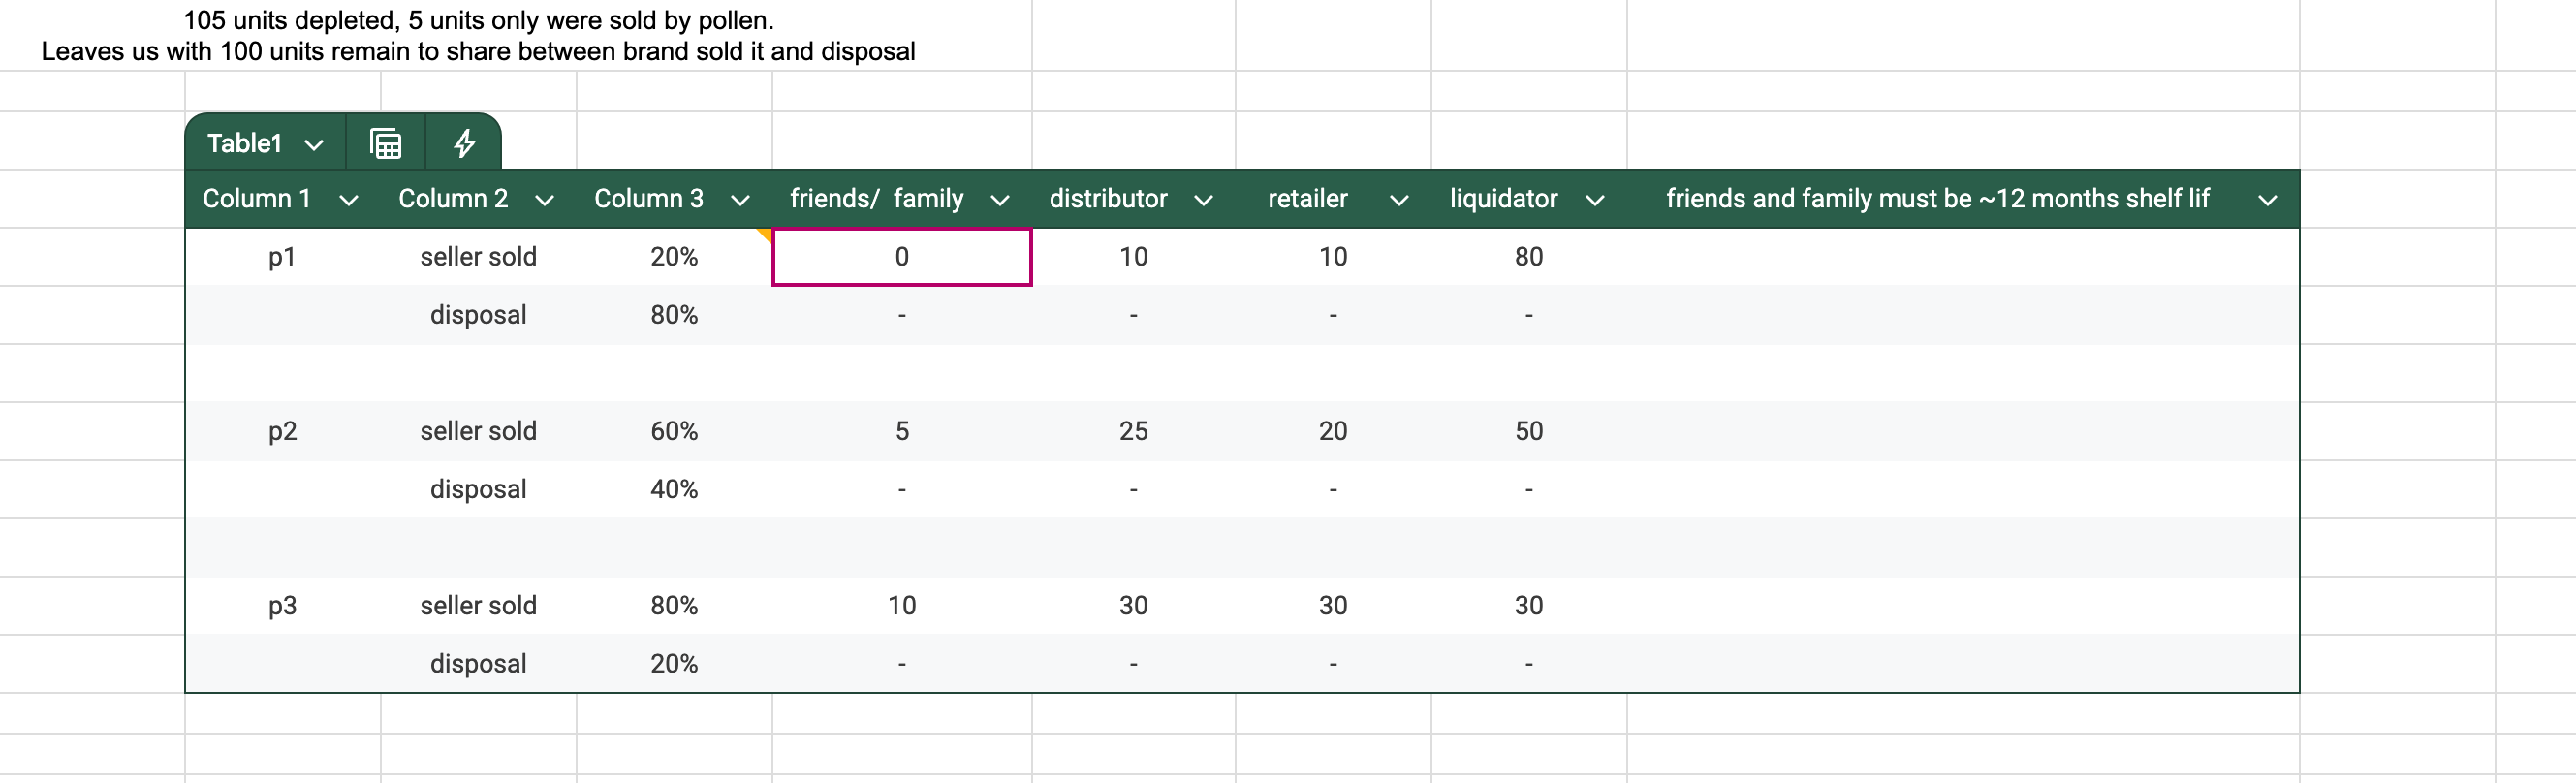

In [116]:
def get_depleted_units_via_liquidation_channel(df):
  if df['priority'] == 'p1':
    if df['liquidation_channel'] == 'friends/family':
      return 0
    elif df['liquidation_channel'] == 'distributor':
      return 0.2 * 0.1 * df['depletion_other_than_pollen']
    elif df['liquidation_channel'] == 'retailer':
      return 0.2 * 0.1 * df['depletion_other_than_pollen']
    elif df['liquidation_channel'] == 'liquidator':
      return 0.2 * 0.8 * df['depletion_other_than_pollen']
    elif df['liquidation_channel'] == 'disposal':
      return 0.8 * df['depletion_other_than_pollen']
    elif df['liquidation_channel'] == 'pollen':
      return df['pollen_liquidated_units']

  if df['priority'] == 'p2':
    if df['liquidation_channel'] == 'friends/family':
      return 0.6 * 0.05 * df['depletion_other_than_pollen']
    elif df['liquidation_channel'] == 'distributor':
      return 0.6 * 0.25 * df['depletion_other_than_pollen']
    elif df['liquidation_channel'] == 'retailer':
      return 0.6 * 0.20 * df['depletion_other_than_pollen']
    elif df['liquidation_channel'] == 'liquidator':
      return 0.6 * 0.5 * df['depletion_other_than_pollen']
    elif df['liquidation_channel'] == 'disposal':
      return 0.4 * df['depletion_other_than_pollen']
    elif df['liquidation_channel'] == 'pollen':
      return df['pollen_liquidated_units']

  if df['priority'] == 'p3':
    if df['liquidation_channel'] == 'friends/family':
      return 0.8 * 0.1 * df['depletion_other_than_pollen']
    elif df['liquidation_channel'] == 'distributor':
      return 0.8 * 0.3 * df['depletion_other_than_pollen']
    elif df['liquidation_channel'] == 'retailer':
      return 0.8 * 0.3 * df['depletion_other_than_pollen']
    elif df['liquidation_channel'] == 'liquidator':
      return 0.8 * 0.3 * df['depletion_other_than_pollen']
    elif df['liquidation_channel'] == 'disposal':
      return 0.2 * df['depletion_other_than_pollen']
    elif df['liquidation_channel'] == 'pollen':
      return df['pollen_liquidated_units']

In [117]:
repeated_inv['final_depletion'] = repeated_inv.apply(get_depleted_units_via_liquidation_channel, axis = 1)
repeated_inv['depletion'] = repeated_inv['final_depletion']
repeated_inv = repeated_inv.drop(['pollen_liquidated_units', 'depletion_other_than_pollen', 'final_depletion', 'pollen_recovery_rate_percentage'], axis = 1)

In [122]:
# after above explode, the relationship between time and liquidation channel + time and depletion number + time and shelf_life_remaining_days_prev
# went for a toss. This is for the correction to keep the sensitivity intact

repeated_inv['channel_group'] = repeated_inv.index // len(['friends/family', 'distributor', 'retailer', 'liquidator', 'disposal', 'pollen'])
max_depletion_in_each_group = repeated_inv.groupby('channel_group').agg({'depletion' : 'max'}).reset_index().rename(columns = {'depletion' : 'max_depletion'})
repeated_inv = pd.merge(repeated_inv, max_depletion_in_each_group, 'left', on = 'channel_group')

In [124]:
def time_correction(df):
  if df['max_depletion'] == 0:
    return df['time']
  else:
    return df['time'] * df['depletion'] / df['max_depletion']

repeated_inv['time'] = repeated_inv.apply(time_correction, axis = 1)

def shelf_life_correction(df):
  if df['depletion'] == 0:
    return df['shelf_life_remaining_days_prev']
  else:
    return df['shelf_life_remaining_days_prev'] * df['max_depletion'] / df['depletion']

repeated_inv['shelf_life_remaining_days_prev'] = repeated_inv.apply(shelf_life_correction, axis = 1)
repeated_inv = repeated_inv.drop(['channel_group', 'max_depletion'], axis = 1)

In [126]:
repeated_inv.head(10)

,sku_number,brand,product_category,product_subcategory,seller_name,time,priority,total_units_prev,depletion,shelf_life_remaining_days_prev,warehouse_country_prev,listing_condition,liquidation_channel
0,20068201,pepsodent,oral_care,tooth_paste,unilever_indonesia,4.666667,p3,12.0,0.96,1431.0,indonesia,excess,friends/family
1,20068201,pepsodent,oral_care,tooth_paste,unilever_indonesia,14.000000,p3,12.0,2.88,477.0,indonesia,excess,distributor
2,20068201,pepsodent,oral_care,tooth_paste,unilever_indonesia,14.000000,p3,12.0,2.88,477.0,indonesia,excess,retailer
3,20068201,pepsodent,oral_care,tooth_paste,unilever_indonesia,14.000000,p3,12.0,2.88,477.0,indonesia,excess,liquidator
4,20068201,pepsodent,oral_care,tooth_paste,unilever_indonesia,11.666667,p3,12.0,2.40,572.4,indonesia,excess,disposal
5,20068201,pepsodent,oral_care,tooth_paste,unilever_indonesia,0.000000,p3,12.0,0.00,477.0,indonesia,excess,pollen
6,20094074,pepsodent,oral_care,tooth_paste,unilever_philippines,0.000000,p3,33552.0,2338.56,1356.0,philippines,damaged,friends/family
7,20094074,pepsodent,oral_care,tooth_paste,unilever_philippines,0.000000,p3,33552.0,7015.68,452.0,philippines,damaged,distributor
8,20094074,pepsodent,oral_care,tooth_paste,unilever_philippines,0.000000,p3,33552.0,7015.68,452.0,philippines,damaged,retailer
9,20094074,pepsodent,oral_care,tooth_paste,unilever_philippines,0.000000,p3,33552.0,7015.68,452.0,philippines,damaged,liquidator


In [127]:
sellers['seller_name'] = sellers['seller_name'].str.lower().str.replace(' ', '_')
sellers['persona_seller_type'] = sellers['persona_seller_type'].str.lower().str.replace(' ', '_')
repeated_inv = pd.merge(repeated_inv, sellers, 'left', on = 'seller_name')
print(repeated_inv.priority.isnull().sum(), repeated_inv.persona_seller_type.isnull().sum())

20904 150


In [128]:
repeated_inv['priority'] = np.where(repeated_inv.priority.isnull(), '', repeated_inv.priority)
repeated_inv['persona_seller_type'] = np.where(repeated_inv.persona_seller_type.isnull(), '', repeated_inv.persona_seller_type)

repeated_inv = repeated_inv[~(repeated_inv['total_units_prev'] == 0)]
repeated_inv['depletion_percent'] = repeated_inv['depletion'] / repeated_inv['total_units_prev']
repeated_inv = repeated_inv[~repeated_inv['depletion_percent'].isnull()]
repeated_inv['depletion_percent'] = repeated_inv['depletion_percent']*100

In [130]:
repeated_inv = repeated_inv.rename(columns = {'warehouse_country_prev' : 'warehouse_country', 'shelf_life_remaining_days_prev' : 'shelf_life_remaining_days'})

In [139]:
print(repeated_inv.shape)
print(repeated_inv[repeated_inv.time < 0].shape)
repeated_inv['time'] = np.where(repeated_inv.time < 0, -repeated_inv.time, repeated_inv.time)

(532674, 15)
(864, 15)


In [141]:
priority_to_shelf_life_median = repeated_inv.groupby('priority').shelf_life_remaining_days.median().reset_index()
priority_to_shelf_life_median = dict(zip(list(priority_to_shelf_life_median.priority), list(priority_to_shelf_life_median.shelf_life_remaining_days)))
priority_to_shelf_life_median

{'p1': 168.0, 'p2': 336.61571388984805, 'p3': 552.1851621937731}

In [142]:
def fill_na_shelf_life_remaining_days(df):
  if pd.isna(df['shelf_life_remaining_days']) and df['priority'] == 'p1':
    return priority_to_shelf_life_median['p1']
  elif pd.isna(df['shelf_life_remaining_days']) and df['priority'] == 'p2':
    return priority_to_shelf_life_median['p2']
  elif pd.isna(df['shelf_life_remaining_days']) and df['priority'] == 'p3':
    return priority_to_shelf_life_median['p3']
  else:
    return df['shelf_life_remaining_days']

repeated_inv['shelf_life_remaining_days'] = repeated_inv.apply(fill_na_shelf_life_remaining_days, axis = 1)

In [143]:
repeated_inv.sample(2)

,sku_number,brand,product_category,product_subcategory,seller_name,time,priority,total_units_prev,depletion,shelf_life_remaining_days,warehouse_country,listing_condition,liquidation_channel,persona_seller_type,depletion_percent
458051,G4239800,l'oreal_paris,makeup,face_makeup,l'oreal_malaysia,0.000000,p3,28.0,0.000000,901.000000,malaysia,fresh,pollen,principal,0.00000
525656,G3355900,l'oreal_paris,skin_care,serums_&_treatments,l'oreal_malaysia,8.030129,p2,6.0,0.584009,766.666667,malaysia,excess,retailer,principal,9.73349


In [147]:
repeated_inv.shape

(532674, 15)

# Prompts

## model prompt 1

In [148]:
# brand_to_time_mapping = repeated_inv.groupby(['brand', 'product_category', 'product_subcategory', 'shelf_life_range', 'seller_name', 'liquidation_channel']).time.median().reset_index()
# prompt_1_df = repeated_inv.groupby(['brand', 'product_category', 'product_subcategory', 'shelf_life_range', 'listing_condition', 'seller_name',
#                                     'liquidation_channel']).agg({'depletion' : 'sum', 'total_units_prev' : 'sum'}).reset_index()
# prompt_1_df = pd.merge(prompt_1_df, brand_to_time_mapping, 'left', on = ['brand', 'product_category', 'product_subcategory', 'shelf_life_range', 'seller_name', 'liquidation_channel'])
# prompt_1_df['depletion_percent'] = prompt_1_df['depletion'] / prompt_1_df['total_units_prev'] * 100
# prompt_1_df = prompt_1_df.drop(['depletion', 'total_units_prev'], axis = 1)

In [149]:
# print(prompt_1_df['time'].isnull().sum())
# prompt_1_df = prompt_1_df[~prompt_1_df['time'].isnull()]
# print(prompt_1_df.shape)

In [150]:
# train_cols = ['brand', 'product_category', 'product_subcategory', 'seller_name', 'shelf_life_range', 'depletion_percent', 'listing_condition', 'liquidation_channel']
# cat_cols = ['brand', 'product_category', 'product_subcategory', 'seller_name', 'shelf_life_range', 'listing_condition', 'liquidation_channel']

In [151]:
# prompt_1_df['time'] = np.log1p(prompt_1_df['time'])

# X_train, X_val, y_train, y_val = train_test_split(prompt_1_df[train_cols], prompt_1_df['time'], test_size = 0.2, random_state = 7)

# # antilogging for different prompts
# prompt_1_df['time'] = np.expm1(prompt_1_df['time'])

In [152]:
# prompt1_model_params = {'loss_function': 'RMSE',
#           'od_wait' : 100,
#           'learning_rate': 0.7,
#           'depth': 4,
#           'min_data_in_leaf': 10}

In [153]:
# def train_catboost(X_train, y_train, X_val, y_val, cat_features, params, iterations = 300, eval_metric = 'RMSE', random_state = 7):
#   model = CatBoostRegressor(**params, iterations = iterations, eval_metric = eval_metric, random_state = random_state)
#   model.fit(X_train, y_train, cat_features=cat_features, eval_set=(X_val, y_val), verbose=True)
#   return model

In [154]:
# model_prompt_1 = train_catboost(X_train, y_train, X_val, y_val, cat_cols, prompt1_model_params, iterations = 1000, eval_metric = 'RMSE', random_state = 7)

In [155]:
# np.exp(y_val)[:20].values

In [156]:
# np.exp(model_prompt_1.predict(X_val))[:20]

## model default 1 - time modeling *(old prompt 7)*

In [157]:
train_cols = ['sku_number', 'brand', 'product_category', 'product_subcategory', 'seller_name', 'shelf_life_remaining_days', 'depletion_percent', 'listing_condition', 'liquidation_channel']
cat_cols = ['sku_number', 'brand', 'product_category', 'product_subcategory', 'seller_name', 'listing_condition', 'liquidation_channel']

print(repeated_inv[train_cols].duplicated().sum())
time_model_df = repeated_inv[train_cols + ['time']]
time_model_df = time_model_df.drop_duplicates(subset = train_cols)
print(time_model_df.shape)

print(time_model_df['time'].isnull().sum())
time_model_df = time_model_df[~time_model_df['time'].isnull()]

85160
(447514, 10)
4091


In [166]:
time_model_df['time'] = np.log1p(time_model_df['time'])

X_train, X_val, y_train, y_val = train_test_split(time_model_df[train_cols], time_model_df['time'], test_size = 0.2, random_state = 7)

# antilogging for different prompts
time_model_df['time'] = np.expm1(time_model_df['time'])

In [167]:
time_model_params = {'loss_function': 'RMSE',
          'od_wait' : 25,
          'learning_rate': 0.8,
          'depth': 5,
          'min_data_in_leaf': 10}

In [168]:
def train_catboost(X_train, y_train, X_val, y_val, cat_features, params, iterations = 300, eval_metric = 'RMSE', random_state = 7):
  model = CatBoostRegressor(**params, iterations = iterations, eval_metric = eval_metric, random_state = random_state)
  model.fit(X_train, y_train, cat_features=cat_features, eval_set=(X_val, y_val), verbose=True)
  return model

In [169]:
time_model = train_catboost(X_train, y_train, X_val, y_val, cat_cols, time_model_params, iterations = 1000, eval_metric = 'RMSE', random_state = 7)

0:	learn: 1.2472802	test: 1.2442217	best: 1.2442217 (0)	total: 460ms	remaining: 7m 39s
1:	learn: 1.1015533	test: 1.0832443	best: 1.0832443 (1)	total: 821ms	remaining: 6m 49s
2:	learn: 1.0487208	test: 1.0239721	best: 1.0239721 (2)	total: 1.41s	remaining: 7m 48s
3:	learn: 1.0285588	test: 1.0004958	best: 1.0004958 (3)	total: 2.15s	remaining: 8m 54s
4:	learn: 1.0103151	test: 0.9761947	best: 0.9761947 (4)	total: 2.81s	remaining: 9m 19s
5:	learn: 0.9962411	test: 0.9604675	best: 0.9604675 (5)	total: 3.57s	remaining: 9m 51s
6:	learn: 0.9825140	test: 0.9442300	best: 0.9442300 (6)	total: 4.22s	remaining: 9m 58s
7:	learn: 0.9761748	test: 0.9385242	best: 0.9385242 (7)	total: 4.91s	remaining: 10m 8s
8:	learn: 0.9716728	test: 0.9341091	best: 0.9341091 (8)	total: 5.37s	remaining: 9m 51s
9:	learn: 0.9634917	test: 0.9242973	best: 0.9242973 (9)	total: 5.74s	remaining: 9m 27s
10:	learn: 0.9575851	test: 0.9178410	best: 0.9178410 (10)	total: 6.12s	remaining: 9m 9s
11:	learn: 0.9489418	test: 0.9086556	best:

In [172]:
np.expm1(y_val)[:20].values

array([ 0.        , 37.84795734,  0.        , 21.83642194,  2.72370651,
       14.05923999, 31.83417429, 24.89397189,  0.        ,  0.        ,
       27.83127451, 20.        , 14.93374694, 18.1791194 , 30.        ,
        0.        ,  0.57263238,  7.98966318, 17.11847492,  0.        ])

In [173]:
np.expm1(time_model.predict(X_val))[:20]

array([-0.4848355 , 43.61307481, 13.59467635,  5.84734323,  2.92024974,
        9.9359643 , 28.41433751, 26.69726105, -0.11224413,  0.3717787 ,
       30.38995073, 17.31664983,  4.20316994, 17.75040454, 43.54624418,
       -0.09304543,  0.85362791,  9.05366613,  5.13110575, -0.20880847])

In [247]:
# ['sku_number', 'brand', 'product_category', 'product_subcategory', 'seller_name', 'shelf_life_remaining_days', 'depletion_percent', 'listing_condition', 'liquidation_channel']
test_data_point = X_val.sample().values[0]
print(list(test_data_point))

['ZTH02629', "l'oreal_paris", 'hair_care', 'hair_color', "l'oreal_thailand", 4813.333333333333, 2.1498230416847632, 'excess', 'friends/family']


In [266]:
test_data_point = ['ZTH02629', "l'oreal_paris", 'hair_care', 'hair_color', "l'oreal_thailand", 700, 80, 'excess', 'friends/family']
np.expm1(time_model.predict(test_data_point))

41.0244913861427

In [176]:
# def dump_files_for_inference_pipeline():
#   print('Dumping files for inference later ...')
#   joblib.dump(low_depletion_cats, '/content/drive/MyDrive/PSI_Modeling_Data/depletion_model/low_depletion_cats.pkl')
#   joblib.dump(mid_depletion_cats, '/content/drive/MyDrive/PSI_Modeling_Data/depletion_model/mid_depletion_cats.pkl')
#   joblib.dump(high_depletion_cats, '/content/drive/MyDrive/PSI_Modeling_Data/depletion_model/high_depletion_cats.pkl')
#   joblib.dump(repeated_inv, '/content/drive/MyDrive/PSI_Modeling_Data/depletion_model/repeated_inv.pkl')
#   joblib.dump(time_model_df, '/content/drive/MyDrive/PSI_Modeling_Data/depletion_model/time_model_df.pkl')
#   joblib.dump(time_model, '/content/drive/MyDrive/PSI_Modeling_Data/depletion_model/time_model.pkl')

In [177]:
# dump_files_for_inference_pipeline()